# Cybersecurity Incident Prediction EDA for DSCI632 Project

David Blankenship: dwb65@drexel.edu


Current Goals:
- get plots for features
- Set up hyperparam tuning
- Run the model
- try GCP, if that fails try here, if that fails subsample.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

from pyspark.sql.functions import col, mean, min, max, count
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

Mounted at /content/gdrive


In [12]:
df = spark.read.csv('/content/gdrive/MyDrive/GUIDE_Train.csv', header=True, inferSchema = True)
df.show(5)

+-------------+-----+----------+-------+-------------------+----------+----------+-----------------+---------------+--------------+-------------+--------------+----------+------------+--------+------+---------+------+----------+----------+---------------+-----------+----------+----------------+--------------+-----------+-----------------+-----------------+-------------+---------------+------------------+------------+--------+----------+--------------+------------+-----+--------+---------+-----------------+--------------+-----------+-----------+-----+-----+
|           Id|OrgId|IncidentId|AlertId|          Timestamp|DetectorId|AlertTitle|         Category|MitreTechniques| IncidentGrade|ActionGrouped|ActionGranular|EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|   Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|EmailClusterId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|ApplicationName|OAuthApplicationId|ThreatFamily|FileName|FolderPa

## Initial Inspection/Preprocessing

In [ ]:
print('Data Shape: ', (df.count(), len(df.columns)))

Data Shape:  (9516837, 45)


In [ ]:
df.printSchema()

root
 |-- Id: long (nullable = true)
 |-- OrgId: integer (nullable = true)
 |-- IncidentId: integer (nullable = true)
 |-- AlertId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- DetectorId: integer (nullable = true)
 |-- AlertTitle: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- MitreTechniques: string (nullable = true)
 |-- IncidentGrade: string (nullable = true)
 |-- ActionGrouped: string (nullable = true)
 |-- ActionGranular: string (nullable = true)
 |-- EntityType: string (nullable = true)
 |-- EvidenceRole: string (nullable = true)
 |-- DeviceId: integer (nullable = true)
 |-- Sha256: integer (nullable = true)
 |-- IpAddress: integer (nullable = true)
 |-- Url: integer (nullable = true)
 |-- AccountSid: integer (nullable = true)
 |-- AccountUpn: integer (nullable = true)
 |-- AccountObjectId: integer (nullable = true)
 |-- AccountName: integer (nullable = true)
 |-- DeviceName: integer (nullable = true)
 |-- NetworkMessageId: i

In [ ]:
df.columns

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City']

In [ ]:
df.groupBy('IncidentGrade').count().show()

+--------------+-------+
| IncidentGrade|  count|
+--------------+-------+
|          NULL|  51340|
|BenignPositive|4110817|
| FalsePositive|2031967|
|  TruePositive|3322713|
+--------------+-------+



In [ ]:
51340/9516837 * 100

0.539464950382149

We see that the nulls in the target is 0.5% of the overall dataset. As the dataset is already enormous I will probably just be dropping these.

In [ ]:
df.filter(df.IncidentGrade.isNull()).count()

51340

### Missing Data Inspection

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+-----+----------+-------+---------+----------+----------+--------+---------------+-------------+-------------+--------------+----------+------------+--------+------+---------+---+----------+----------+---------------+-----------+----------+----------------+--------------+-----------+-----------------+-----------------+-------------+---------------+------------------+------------+--------+----------+--------------+------------+-------+--------+---------+-----------------+--------------+-----------+-----------+-----+----+
| Id|OrgId|IncidentId|AlertId|Timestamp|DetectorId|AlertTitle|Category|MitreTechniques|IncidentGrade|ActionGrouped|ActionGranular|EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|EmailClusterId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|ApplicationName|OAuthApplicationId|ThreatFamily|FileName|FolderPath|ResourceIdName|ResourceType|  Roles|OSFamily|OSVersion|Antispa

MitreTechniques, ActionGrouped, ActionGranular, EmailClusterId, ThreatFamily, ResourceType, Roles, AntispamDirection, SuspicionLevel, and LastVerdict lack enough data that I will be dropping these columns. I will look at MitreTechniques first.

Otherwise the dataset is mostly good aside from the target nulls we saw earlier.

In [13]:
missing_cols = ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'IncidentGrade']

for c in missing_cols:
  print(c, ": ", df.filter(df[c].isNull()).count())

MitreTechniques :  5468386
ActionGrouped :  9460773
ActionGranular :  9460773
EmailClusterId :  9420025
ThreatFamily :  9441956
ResourceType :  9509762
Roles :  9298686
AntispamDirection :  9339535
SuspicionLevel :  8072708
LastVerdict :  7282572
IncidentGrade :  51340


In [15]:
for c in missing_cols:
  print(c, " Missing Percent: ", (df.filter(df[c].isNull()).count()/df.count()) * 100)

MitreTechniques  Missing Percent:  57.4601204160584
ActionGrouped  Missing Percent:  99.41089670864385
ActionGranular  Missing Percent:  99.41089670864385
EmailClusterId  Missing Percent:  98.98272924081814
ThreatFamily  Missing Percent:  99.21317345248217
ResourceType  Missing Percent:  99.92565807316024
Roles  Missing Percent:  97.7077362993608
AntispamDirection  Missing Percent:  98.1369650441633
SuspicionLevel  Missing Percent:  84.8255360473233
LastVerdict  Missing Percent:  76.52302965785796
IncidentGrade  Missing Percent:  0.539464950382149


In [ ]:
df.groupBy('MitreTechniques').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|     MitreTechniques|  count|
+--------------------+-------+
|                NULL|5468386|
|     T1078;T1078.004|1354904|
|           T1566.002| 814308|
|               T1566| 659591|
|               T1133| 145579|
|           T1566.001| 136892|
|T1110;T1110.003;T...|  88661|
|     T1087;T1087.002|  54564|
|               T1110|  41768|
|         T1078;T1098|  40342|
|T1559;T1106;T1059...|  37869|
|   T1046;T1071;T1210|  34229|
|         T1568;T1008|  33335|
|         T1110;T1078|  31570|
|         T1190;T1133|  31379|
|T1046;T1030;T1071...|  28769|
|               T1078|  27371|
|T1003;T1012;T1552...|  22170|
|               T1190|  20214|
|         T1071;T1048|  19526|
+--------------------+-------+
only showing top 20 rows



MITRE Techniques are a categorization of the specific methods involved in the cybersecurity incident.

https://attack.mitre.org/techniques/T1078/

The most common non-null value is a T1078 incident, which is an incident involving valid accounts. T1078.004 in particular is a cloud account which I find hilariously relevant to this class.

While valuable information the high volume of missing data likely means it has to be dropped. I am extremely torn on this though and suspect it would be best for future work. I will return to this and do some analysis on this column



In [ ]:
df.dtypes

[('Id', 'bigint'),
 ('OrgId', 'int'),
 ('IncidentId', 'int'),
 ('AlertId', 'int'),
 ('Timestamp', 'timestamp'),
 ('DetectorId', 'int'),
 ('AlertTitle', 'int'),
 ('Category', 'string'),
 ('MitreTechniques', 'string'),
 ('IncidentGrade', 'string'),
 ('ActionGrouped', 'string'),
 ('ActionGranular', 'string'),
 ('EntityType', 'string'),
 ('EvidenceRole', 'string'),
 ('DeviceId', 'int'),
 ('Sha256', 'int'),
 ('IpAddress', 'int'),
 ('Url', 'int'),
 ('AccountSid', 'int'),
 ('AccountUpn', 'int'),
 ('AccountObjectId', 'int'),
 ('AccountName', 'int'),
 ('DeviceName', 'int'),
 ('NetworkMessageId', 'int'),
 ('EmailClusterId', 'double'),
 ('RegistryKey', 'int'),
 ('RegistryValueName', 'int'),
 ('RegistryValueData', 'int'),
 ('ApplicationId', 'int'),
 ('ApplicationName', 'int'),
 ('OAuthApplicationId', 'int'),
 ('ThreatFamily', 'string'),
 ('FileName', 'int'),
 ('FolderPath', 'int'),
 ('ResourceIdName', 'int'),
 ('ResourceType', 'string'),
 ('Roles', 'string'),
 ('OSFamily', 'int'),
 ('OSVersion', '


 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped',
 'ActionGranular', 'EntityType', 'EvidenceRole', 'ThreatFamily',
 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel',
 'LastVerdict'

Now while these are the strings it seems like a lot of these even nominally int values are actually categoricals. Need to look into this.

In [ ]:
for f in df.columns:
  value = df.select(f).distinct().count()
  print(f, ": ", str(value), " unique values")

Id :  730778  unique values
OrgId :  5769  unique values
IncidentId :  466151  unique values
AlertId :  1265644  unique values
Timestamp :  760944  unique values
DetectorId :  8428  unique values
AlertTitle :  86149  unique values
Category :  20  unique values
MitreTechniques :  1194  unique values
IncidentGrade :  4  unique values
ActionGrouped :  4  unique values
ActionGranular :  17  unique values
EntityType :  33  unique values
EvidenceRole :  2  unique values
DeviceId :  75826  unique values
Sha256 :  106416  unique values
IpAddress :  285957  unique values
Url :  123252  unique values
AccountSid :  358401  unique values
AccountUpn :  530183  unique values
AccountObjectId :  343516  unique values
AccountName :  368250  unique values
DeviceName :  114541  unique values
NetworkMessageId :  375196  unique values
EmailClusterId :  26475  unique values
RegistryKey :  1341  unique values
RegistryValueName :  525  unique values
RegistryValueData :  699  unique values
ApplicationId :  172

## Test Set Inspection
Looking at basic features of test set to ensure no issues and verify any need for further data cleaning.


In [ ]:
df_test = spark.read.csv('/content/gdrive/MyDrive/GUIDE_Test.csv', header=True, inferSchema = True)
df_test.show(5)

+-------------+-----+----------+-------+-------------------+----------+----------+-----------------+--------------------+--------------+-------------+--------------+-----------------+------------+--------+------+---------+------+----------+----------+---------------+-----------+----------+----------------+--------------+-----------+-----------------+-----------------+-------------+---------------+------------------+------------+--------+----------+--------------+------------+----------+--------+---------+-----------------+--------------+-----------+-----------+-----+-----+-------+
|           Id|OrgId|IncidentId|AlertId|          Timestamp|DetectorId|AlertTitle|         Category|     MitreTechniques| IncidentGrade|ActionGrouped|ActionGranular|       EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|   Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|EmailClusterId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|ApplicationName|OAuthApplica

In [ ]:
print('Data Shape: ', (df_test.count(), len(df_test.columns)))

Data Shape:  (4147992, 46)


In [2]:
4147992/(9516837+4147992)

0.30355242645187874

In [ ]:
df_test.printSchema()

root
 |-- Id: long (nullable = true)
 |-- OrgId: integer (nullable = true)
 |-- IncidentId: integer (nullable = true)
 |-- AlertId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- DetectorId: integer (nullable = true)
 |-- AlertTitle: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- MitreTechniques: string (nullable = true)
 |-- IncidentGrade: string (nullable = true)
 |-- ActionGrouped: string (nullable = true)
 |-- ActionGranular: string (nullable = true)
 |-- EntityType: string (nullable = true)
 |-- EvidenceRole: string (nullable = true)
 |-- DeviceId: integer (nullable = true)
 |-- Sha256: integer (nullable = true)
 |-- IpAddress: integer (nullable = true)
 |-- Url: integer (nullable = true)
 |-- AccountSid: integer (nullable = true)
 |-- AccountUpn: integer (nullable = true)
 |-- AccountObjectId: integer (nullable = true)
 |-- AccountName: integer (nullable = true)
 |-- DeviceName: integer (nullable = true)
 |-- NetworkMessageId: i

The Usage column is unique to the test set and not relevant to our problem. I will simply be dropping this column.

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = df_test.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_test.columns])
null_counts.show()

+---+-----+----------+-------+---------+----------+----------+--------+---------------+-------------+-------------+--------------+----------+------------+--------+------+---------+---+----------+----------+---------------+-----------+----------+----------------+--------------+-----------+-----------------+-----------------+-------------+---------------+------------------+------------+--------+----------+--------------+------------+-------+--------+---------+-----------------+--------------+-----------+-----------+-----+----+-----+
| Id|OrgId|IncidentId|AlertId|Timestamp|DetectorId|AlertTitle|Category|MitreTechniques|IncidentGrade|ActionGrouped|ActionGranular|EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|EmailClusterId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|ApplicationName|OAuthApplicationId|ThreatFamily|FileName|FolderPath|ResourceIdName|ResourceType|  Roles|OSFamily|OSVersion|A

MitreTechniques, ActionGrouped, ActionGranular, EmailClusterId, ThreatFamily, ResourceType, Roles, AntispamDirection, SuspicionLevel, and LastVerdict all have missing values. These are, very convieniently, the same columns as the train set so I will be dropping them.

## Univariate Analyses

### Categoricals

- Category
- IncidentGrade
- ActionGrouped
- ActionGranular
- EvidenceRole
- ResourceType
- Roles
- OSFamily
- AntispamDirection
- SuspicionLevel
- LastVerdict
- EntityType
- OSVersion

In [ ]:
df.groupBy('Category').count().orderBy('count', ascending=False).show()

+-------------------+-------+
|           Category|  count|
+-------------------+-------+
|      InitialAccess|4293041|
|       Exfiltration|1577965|
| SuspiciousActivity|1003933|
|  CommandAndControl| 826691|
|             Impact| 750885|
|   CredentialAccess| 300518|
|          Execution| 267594|
|            Malware| 144081|
|          Discovery| 129342|
|        Persistence|  72682|
|     DefenseEvasion|  46662|
|    LateralMovement|  41754|
|         Ransomware|  18974|
|   UnwantedSoftware|  18211|
|         Collection|  14753|
|PrivilegeEscalation|   4671|
|            Exploit|   4648|
| CredentialStealing|    388|
|         WebExploit|     38|
|      Weaponization|      6|
+-------------------+-------+



In [ ]:
df.groupBy('IncidentGrade').count().orderBy('count', ascending=False).show()

+--------------+-------+
| IncidentGrade|  count|
+--------------+-------+
|BenignPositive|4110817|
|  TruePositive|3322713|
| FalsePositive|2031967|
|          NULL|  51340|
+--------------+-------+



In [ ]:
df.groupBy('ActionGrouped').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|       ActionGrouped|  count|
+--------------------+-------+
|                NULL|9460773|
|      ContainAccount|  53760|
|       IsolateDevice|   2237|
|Stop Virtual Mach...|     67|
+--------------------+-------+



In [ ]:
df.groupBy('ActionGranular').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|      ActionGranular|  count|
+--------------------+-------+
|                NULL|9460773|
|update stsrefresh...|  21393|
|account password ...|  14059|
|change user passw...|  13623|
|     isolateresponse|   2043|
|    account disabled|   1991|
|    disable account.|   1143|
|reset user password.|    886|
|forcepasswordrese...|    234|
|      quarantinefile|    194|
|msecidentitiescon...|    146|
|         disableuser|    107|
|msecidentitiessus...|     81|
|delete virtualmac...|     67|
|     account deleted|     55|
|        delete user.|     35|
|set force change ...|      7|
+--------------------+-------+



In [ ]:
df.groupBy('EvidenceRole').count().orderBy('count', ascending=False).show()

+------------+-------+
|EvidenceRole|  count|
+------------+-------+
|     Related|5208644|
|    Impacted|4308193|
+------------+-------+



In [ ]:
df.groupBy('ResourceType').count().orderBy('count', ascending=False).show(26)

+--------------------+-------+
|        ResourceType|  count|
+--------------------+-------+
|                NULL|9509762|
|     Virtual Machine|   4146|
|           Key Vault|    480|
|         App Service|    404|
|   Azure Arc machine|    373|
|     Storage Account|    366|
|        Subscription|    271|
|        SQL Database|    226|
|Azure Database fo...|    182|
|      Azure Resource|    157|
|Virtual Machine S...|    112|
|API Management Se...|     94|
|    Key Vault Secret|     77|
|Azure Database fo...|     45|
|          SQL Server|     41|
|Azure Cosmos DB A...|     30|
|          Networking|     14|
|    Synapse SQL Pool|     11|
|GCP Compute Instance|     10|
|  Kubernetes Service|      9|
|SQL Managed Instance|      9|
|Key Vault Certifi...|      7|
|    AWS EC2 Instance|      6|
|       Key Vault Key|      2|
|   Synapse Workspace|      2|
|   Cognitive Service|      1|
+--------------------+-------+



In [ ]:
df.groupBy('Roles').count().orderBy('count', ascending=False).show()

+--------------+-------+
|         Roles|  count|
+--------------+-------+
|          NULL|9298686|
|    Contextual| 130528|
|   Destination|  34324|
|    Suspicious|  28952|
|      Attacker|  13096|
|        Source|   7171|
|   Compromised|   3219|
|PolicyViolator|    666|
|      Attacked|    188|
|        Edited|      6|
|         Added|      1|
+--------------+-------+



In [ ]:
df.groupBy('OSFamily').count().orderBy('count', ascending=False).show()

+--------+-------+
|OSFamily|  count|
+--------+-------+
|       5|9322565|
|       0| 190036|
|       1|   2732|
|       2|   1496|
|       3|      7|
|       4|      1|
+--------+-------+



5 is overwhelming represented in this dataset. Is this sampling bias or reflective of targeting?

In [ ]:
df.groupBy('AntispamDirection').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|   AntispamDirection|  count|
+--------------------+-------+
|                NULL|9339535|
|             Inbound| 161111|
|            Intraorg|  15308|
|            Outbound|    868|
|DomainPII_50d8b4a...|     10|
|DomainPII_df80ab8...|      5|
+--------------------+-------+



In [ ]:
df.groupBy('SuspicionLevel').count().orderBy('count', ascending=False).show()

+--------------+-------+
|SuspicionLevel|  count|
+--------------+-------+
|          NULL|8072708|
|    Suspicious|1442614|
|  Incriminated|   1515|
+--------------+-------+



In [ ]:
df.groupBy('LastVerdict').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|         LastVerdict|  count|
+--------------------+-------+
|                NULL|7282572|
|          Suspicious|1402997|
|           Malicious| 433359|
|      NoThreatsFound| 397718|
|DomainPII_50d8b4a...|    128|
|DomainPII_9207384...|     63|
+--------------------+-------+



In [ ]:
df.groupBy('EntityType').count().orderBy('count', ascending=False).show()

+-----------------+-------+
|       EntityType|  count|
+-----------------+-------+
|               Ip|2181194|
|             User|1932416|
|      MailMessage|1173154|
|          Machine| 699208|
|             File| 688402|
|              Url| 682578|
|CloudLogonRequest| 638565|
|          Mailbox| 483158|
|          Process| 345732|
|      MailCluster| 224684|
| CloudApplication| 216811|
|CloudLogonSession| 212382|
|    RegistryValue|  11209|
|    AzureResource|   8166|
|      RegistryKey|   7277|
|    GenericEntity|   4294|
| OAuthApplication|   2595|
|          Malware|   2580|
|    SecurityGroup|   1518|
|    BlobContainer|    306|
+-----------------+-------+
only showing top 20 rows



In [ ]:
df.groupBy('OSVersion').count().orderBy('count', ascending=False).show()

+---------+-------+
|OSVersion|  count|
+---------+-------+
|       66|9322572|
|        0| 187405|
|        2|   1892|
|        1|   1652|
|        3|   1125|
|        4|    732|
|        6|    362|
|        5|    266|
|        8|    132|
|        9|    109|
|       10|     89|
|        7|     81|
|       11|     66|
|       12|     54|
|       16|     38|
|       13|     32|
|       14|     31|
|       15|     22|
|       19|     18|
|       17|     17|
+---------+-------+
only showing top 20 rows



OSVersion 66 is overwhelmingly represented here. As with OS could refelct sampling bias or actual target selection. Also I am inclined to treat OSversiona and family as numericals or ordinals.

In [ ]:
df.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict')

+-------------+-----+----------+-------+-------------------+----------+----------+------------------+--------------+----------------+------------+--------+------+---------+------+----------+----------+---------------+-----------+----------+----------------+-----------+-----------------+-----------------+-------------+---------------+------------------+--------+----------+--------------+--------+---------+-----------+-----+-----+
|           Id|OrgId|IncidentId|AlertId|          Timestamp|DetectorId|AlertTitle|          Category| IncidentGrade|      EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|   Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|ApplicationName|OAuthApplicationId|FileName|FolderPath|ResourceIdName|OSFamily|OSVersion|CountryCode|State| City|
+-------------+-----+----------+-------+-------------------+----------+----------+------------------+--------------+----------------+-

In [ ]:
df.groupBy('RegistryKey').count().orderBy('count', ascending=False).show()

+-----------+-------+
|RegistryKey|  count|
+-----------+-------+
|       1631|9499313|
|          0|  11076|
|          1|    245|
|          3|    235|
|          6|    141|
|          4|    136|
|          5|    131|
|          8|    118|
|          7|     98|
|         12|     75|
|          9|     70|
|         11|     66|
|         10|     66|
|         15|     58|
|          2|     53|
|         13|     44|
|         16|     40|
|         17|     36|
|         24|     36|
|         25|     34|
+-----------+-------+
only showing top 20 rows



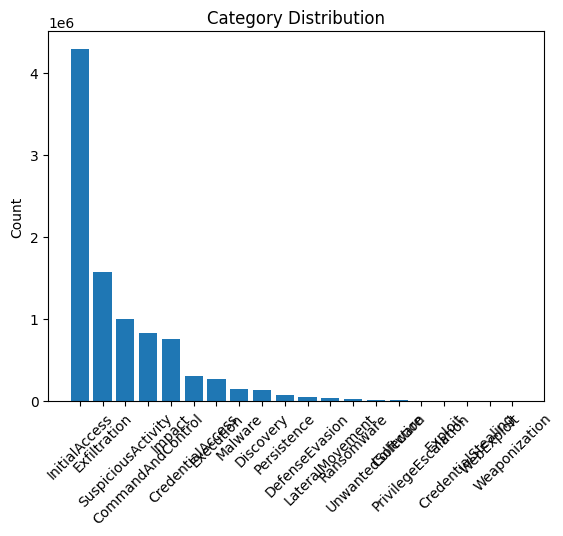

In [ ]:
# need to fix output but this is the structure

df_grouped = df.groupBy("Category").count().orderBy(col("count").desc())

# Convert to Pandas for plotting
pdf = df_grouped.toPandas()

# Bar plot
plt.bar(pdf["Category"], pdf["count"])
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Category Distribution")
plt.show()

In [ ]:
df.crosstab('Sex', 'Survived').show()

### Numericals

In [19]:
df.columns

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'MitreTechniques',
 'IncidentGrade',
 'ActionGrouped',
 'ActionGranular',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'EmailClusterId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'ThreatFamily',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'ResourceType',
 'Roles',
 'OSFamily',
 'OSVersion',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict',
 'CountryCode',
 'State',
 'City']

In [22]:
num_col = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
            'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
            'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
            'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
            'RegistryValueData', 'ApplicationId', 'EmailClusterId',
            'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName',
            'FolderPath', 'ResourceIdName', 'CountryCode', 'State', 'City']

In [23]:
from pyspark.sql.functions import mean, min, max
for c in num_col:
  df.select(mean(c), min(c), max(c)).show()


+--------------------+-------+-------------+
|             avg(Id)|min(Id)|      max(Id)|
+--------------------+-------+-------------+
|8.425494025715468E11|      0|1709396988938|
+--------------------+-------+-------------+

+------------------+----------+----------+
|        avg(OrgId)|min(OrgId)|max(OrgId)|
+------------------+----------+----------+
|181.57995014520054|         0|      6147|
+------------------+----------+----------+

+-----------------+---------------+---------------+
|  avg(IncidentId)|min(IncidentId)|max(IncidentId)|
+-----------------+---------------+---------------+
|70663.48631630446|              0|         599706|
+-----------------+---------------+---------------+

+----------------+------------+------------+
|    avg(AlertId)|min(AlertId)|max(AlertId)|
+----------------+------------+------------+
|406518.829002325|           0|     1721456|
+----------------+------------+------------+

+-----------------+---------------+---------------+
|  avg(DetectorId)|

In [24]:
for c in num_col:
  df.select(c).describe().show() # maybe .summary

+-------+--------------------+
|summary|                  Id|
+-------+--------------------+
|  count|             9516837|
|   mean|8.425494025715468E11|
| stddev|4.962498750397234...|
|    min|                   0|
|    max|       1709396988938|
+-------+--------------------+

+-------+------------------+
|summary|             OrgId|
+-------+------------------+
|  count|           9516837|
|   mean|181.57995014520054|
| stddev|386.77837703936484|
|    min|                 0|
|    max|              6147|
+-------+------------------+

+-------+------------------+
|summary|        IncidentId|
+-------+------------------+
|  count|           9516837|
|   mean| 70663.48631630446|
| stddev|120836.85320205832|
|    min|                 0|
|    max|            599706|
+-------+------------------+

+-------+------------------+
|summary|           AlertId|
+-------+------------------+
|  count|           9516837|
|   mean|  406518.829002325|
| stddev|459282.69751793233|
|    min|             

In [ ]:
for c in num_col:
  df.select(c).summary().show()

Histograms

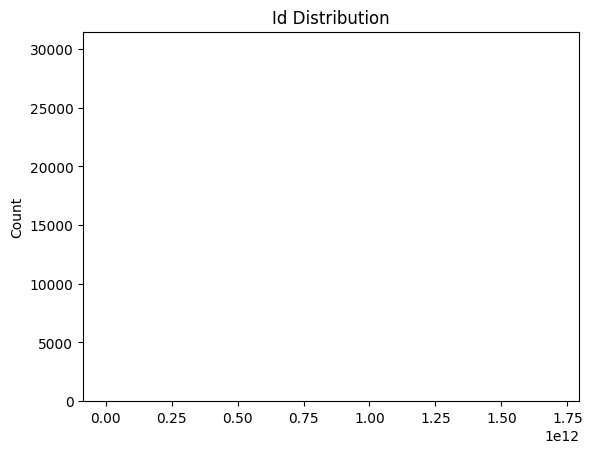

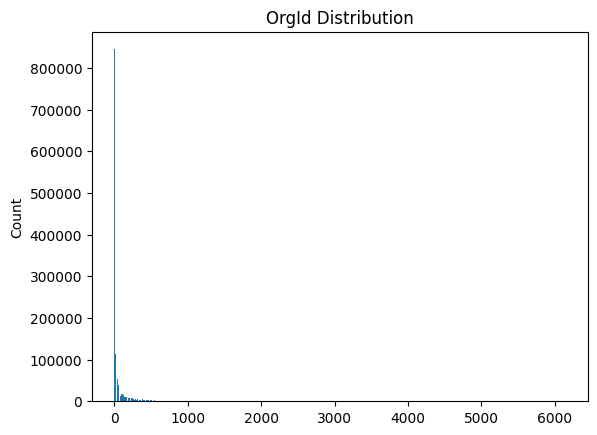

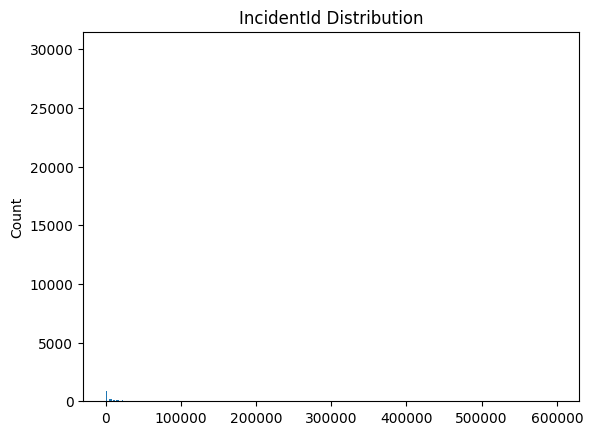

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7a736fe696c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7a736fe3b060> (for post_execute):


KeyboardInterrupt: 

In [25]:
for c in num_col:
  df_grouped = df.groupBy(c).count().orderBy(col("count").desc())

  # Convert to Pandas for plotting
  pdf = df_grouped.toPandas()

  # Bar plot
  plt.bar(pdf[c], pdf["count"])
  # plt.xticks(rotation=45)
  plt.ylabel("Count")
  plt.title(f"{c} Distribution")
  plt.show()

## Time Feature and Transformation
 Should probably move this so time is part of the transformation pipeline. For now though looking at this to get an understanding of time.



In [ ]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second, dayofweek, weekofyear

df = df.withColumn("year", year(df["Timestamp"])) \
       .withColumn("month", month(df["Timestamp"])) \
       .withColumn("day", dayofmonth(df["Timestamp"])) \
       .withColumn("hour", hour(df["Timestamp"])) \
       .withColumn("minute", minute(df["Timestamp"])) \
       .withColumn("second", second(df["Timestamp"])) \
       .withColumn("day_of_week", dayofweek(df["Timestamp"])) \
       .withColumn("week_of_year", weekofyear(df["Timestamp"]))
df.show(5)

+-------------+-----+----------+-------+-------------------+----------+----------+-----------------+---------------+--------------+-------------+--------------+----------+------------+--------+------+---------+------+----------+----------+---------------+-----------+----------+----------------+--------------+-----------+-----------------+-----------------+-------------+---------------+------------------+------------+--------+----------+--------------+------------+-----+--------+---------+-----------------+--------------+-----------+-----------+-----+-----+----+-----+---+----+------+------+-----------+------------+
|           Id|OrgId|IncidentId|AlertId|          Timestamp|DetectorId|AlertTitle|         Category|MitreTechniques| IncidentGrade|ActionGrouped|ActionGranular|EntityType|EvidenceRole|DeviceId|Sha256|IpAddress|   Url|AccountSid|AccountUpn|AccountObjectId|AccountName|DeviceName|NetworkMessageId|EmailClusterId|RegistryKey|RegistryValueName|RegistryValueData|ApplicationId|Applic

In [ ]:
df.groupBy('year').count().orderBy('count', ascending=False).show()

+----+-------+
|year|  count|
+----+-------+
|2024|9516658|
|2023|    179|
+----+-------+



In [ ]:
df.groupBy('month').count().orderBy('count', ascending=False).show()

+-----+-------+
|month|  count|
+-----+-------+
|    6|8662447|
|    5| 853082|
|    1|    310|
|    2|    297|
|    4|    287|
|    3|    235|
|   12|    168|
|   11|     11|
+-----+-------+



We see a very heavy bias towards 2024 and June. I'll still be using these time features as having them tends to be better for data but still its something to be aware of how biased it appears in smapling.

## Mitre Techniques Analysis

While we will be removing this column due to the volume of missing values, inspecting it is likely to pay dividends in understanding the nature of the most common attacks in the dataset.

In [5]:
mitre_count = df.groupBy('MitreTechniques').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|     MitreTechniques|  count|
+--------------------+-------+
|                NULL|5468386|
|     T1078;T1078.004|1354904|
|           T1566.002| 814308|
|               T1566| 659591|
|               T1133| 145579|
|           T1566.001| 136892|
|T1110;T1110.003;T...|  88661|
|     T1087;T1087.002|  54564|
|               T1110|  41768|
|         T1078;T1098|  40342|
|T1559;T1106;T1059...|  37869|
|   T1046;T1071;T1210|  34229|
|         T1568;T1008|  33335|
|         T1110;T1078|  31570|
|         T1190;T1133|  31379|
|T1046;T1030;T1071...|  28769|
|               T1078|  27371|
|T1003;T1012;T1552...|  22170|
|               T1190|  20214|
|         T1071;T1048|  19526|
+--------------------+-------+
only showing top 20 rows



In [8]:
mitre_count_nonull = df.filter(df.MitreTechniques.isNotNull()).groupBy('MitreTechniques').count().orderBy('count', ascending=False).show()

+--------------------+-------+
|     MitreTechniques|  count|
+--------------------+-------+
|     T1078;T1078.004|1354904|
|           T1566.002| 814308|
|               T1566| 659591|
|               T1133| 145579|
|           T1566.001| 136892|
|T1110;T1110.003;T...|  88661|
|     T1087;T1087.002|  54564|
|               T1110|  41768|
|         T1078;T1098|  40342|
|T1559;T1106;T1059...|  37869|
|   T1046;T1071;T1210|  34229|
|         T1568;T1008|  33335|
|         T1110;T1078|  31570|
|         T1190;T1133|  31379|
|T1046;T1030;T1071...|  28769|
|               T1078|  27371|
|T1003;T1012;T1552...|  22170|
|               T1190|  20214|
|         T1071;T1048|  19526|
|T1110;T1110.001;T...|  17457|
+--------------------+-------+
only showing top 20 rows



In [28]:
from pyspark.sql.functions import col, count

top_attacks = (
    df.filter(df.MitreTechniques.isNotNull())
    .groupBy("MitreTechniques")
    .agg(count("*").alias("count"))
    .orderBy(col("count").desc())
    .limit(10)
)

df_filtered = df.join(top_attacks, on="MitreTechniques", how="inner")
df_filtered.stat.crosstab("MitreTechniques", "IncidentGrade").show(truncate=False)

+-----------------------------+--------------+-------------+------------+----+
|MitreTechniques_IncidentGrade|BenignPositive|FalsePositive|TruePositive|null|
+-----------------------------+--------------+-------------+------------+----+
|T1078;T1078.004              |35897         |308347       |1009935     |725 |
|T1087;T1087.002              |23935         |21831        |8782        |16  |
|T1566                        |346566        |167763       |141964      |3298|
|T1110;T1110.003;T1110.001    |1549          |3102         |84002       |8   |
|T1133                        |19124         |126455       |0           |0   |
|T1559;T1106;T1059.005        |37869         |0            |0           |0   |
|T1566.001                    |90698         |7398         |38792       |4   |
|T1566.002                    |391993        |128955       |292731      |629 |
|T1078;T1098                  |35268         |3721         |1341        |12  |
|T1110                        |24047         |7081  

# Machine Learning Component Staging

I still want to try doing this in Google Cloud, but I want to at least stage the inputs I will be using.

In [ ]:
"""
Steps
-----
read in csv's (Train and Test)

drop appropriate columns

drop nulls in target

Pipeline with:
transforms
- time (see above)
- categoricals
- numericals
No scaling needed due to model selection

Create ml models
-Naive Bayes
-Gradient Boosted Tree Classifier

run ml models

evaluate models
-F1
-Precision
-Recall
-Macro F1
-confusion matrix
-ROC?
-AUC?
"""

In [ ]:
df_train = df.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict').dropna(subset=['IncidentGrade'])
df_test.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'Usage')


In [ ]:
df_drop = df.drop('MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict').dropna(subset=['IncidentGrade'])
df_drop.printSchema()

root
 |-- Id: long (nullable = true)
 |-- OrgId: integer (nullable = true)
 |-- IncidentId: integer (nullable = true)
 |-- AlertId: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- DetectorId: integer (nullable = true)
 |-- AlertTitle: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- IncidentGrade: string (nullable = true)
 |-- EntityType: string (nullable = true)
 |-- EvidenceRole: string (nullable = true)
 |-- DeviceId: integer (nullable = true)
 |-- Sha256: integer (nullable = true)
 |-- IpAddress: integer (nullable = true)
 |-- Url: integer (nullable = true)
 |-- AccountSid: integer (nullable = true)
 |-- AccountUpn: integer (nullable = true)
 |-- AccountObjectId: integer (nullable = true)
 |-- AccountName: integer (nullable = true)
 |-- DeviceName: integer (nullable = true)
 |-- NetworkMessageId: integer (nullable = true)
 |-- RegistryKey: integer (nullable = true)
 |-- RegistryValueName: integer (nullable = true)
 |-- RegistryValueD

In [ ]:
print('Data Shape: ', (df_drop.count(), len(df_drop.columns)))

Data Shape:  (9465497, 43)


In [ ]:
df_drop.columns

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'Category',
 'IncidentGrade',
 'EntityType',
 'EvidenceRole',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'OSFamily',
 'OSVersion',
 'CountryCode',
 'State',
 'City',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'day_of_week',
 'week_of_year']

## Naive Bayes Pipeline and Model

In [ ]:
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second, dayofweek, weekofyear
from pyspark.sql import DataFrame
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

In [ ]:
class TimestampFeatureTransformer(Transformer):
    def __init__(self):
        super(TimestampFeatureTransformer, self).__init__()

    def _transform(self, df: DataFrame) -> DataFrame:
        return df.withColumn("year", year(df["timestamp_col"])) \
                 .withColumn("month", month(df["timestamp_col"])) \
                 .withColumn("day", dayofmonth(df["timestamp_col"])) \
                 .withColumn("hour", hour(df["timestamp_col"])) \
                 .withColumn("minute", minute(df["timestamp_col"])) \
                 .withColumn("second", second(df["timestamp_col"])) \
                 .withColumn("day_of_week", dayofweek(df["timestamp_col"])) \
                 .withColumn("week_of_year", weekofyear(df["timestamp_col"]))

# Instantiate the transformer
timestamp_transformer = TimestampFeatureTransformer()

In [ ]:
pipe_stages = [StringIndexer(inputCol=c, output=c+'_index') for c in ['Category', 'EntityType', 'EvidenceRole']]
pipe_stages.append(StringIndexer(inputCol='IncidentGrade', output='target'))
# ohe stuff here
pipe_stages.append(OneHotEncoder(inputCols=[c+'_index' for c in ['Category', 'EntityType', 'EvidenceRole']], outputCols=[c+'_ohe' for c in ['Category', 'EntityType', 'EvidenceRole']]))

feature_cols = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId',
                'AlertTitle', 'Category_ohe', 'EntityType_ohe', 'EvidenceRole_ohe',
                'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
                'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
                'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId',
                'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath',
                'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State',
                'City', 'year', 'month', 'day', 'hour', 'minute', 'second',
                'day_of_week', 'week_of_year']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
pipe_stages.append(assembler)

pipeline = Pipeline(stages=[timestamp_transformer, pipe_stages])

df_train_transformed = pipeline.fit(df_train).transform(df_train)
df_test_transformed = pipeline.fit(df_test).transform(df_test)

In [ ]:
nb = NaiveBayes(featuresCol='features', labelCol='target')
nb_model = nb.fit(df_train_transformed)

train_prediction = nb_model.transform(df_train_transformed)
test_prediction = nb_model.transform(df_test_transformed)

## Evaluations

In [ ]:
# Evaluators
evaluator_macrof1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="fMeasureByLabel")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")

Train Set Evaluation

In [ ]:
train_macrof1 = evaluator_macrof1.evaluate(train_prediction)
train_f1 = evaluator_f1.evaluate(train_prediction)
train_precision = evaluator_precision.evaluate(train_prediction)
train_recall = evaluator_recall.evaluate(train_prediction)

test_macrof1 = evaluator_macrof1.evaluate(test_prediction)
test_f1 = evaluator_f1.evaluate(test_prediction)
test_precision = evaluator_precision.evaluate(test_prediction)
test_recall = evaluator_recall.evaluate(test_prediction)


print(f"Train Macro-F1: {train_macrof1}")
print(f"Train F1 by Class: {train_f1}")
print(f"Train Precision by Class: {train_precision}")
print(f"Train Recall by Class: {train_recall}")
print()
print(f"Test Macro-F1: {test_macrof1}")
print(f"Test F1 by Class: {test_f1}")
print(f"Test Precision by Class: {test_precision}")
print(f"Test Recall by Class: {test_recall}")

In [ ]:
# Confusion Matrix for Train Set
train_crosstab = train_prediction.stat.crosstab("label", "prediction")
train_crosstab.show()

In [ ]:
# Confusion Matrix for Test Set
test_crosstab = test_prediction.stat.crosstab("label", "prediction")
test_crosstab.show()

## Gradient Boosted Tree Classifier Pipeline and Model

Need to insert hyperparam tuning

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbtc = GBTClassifier(featuresCol='features', labelCol='target')
gbtc_model = gbtc.fit(df_train_transformed)

train_prediction = gbtc_model.transform(df_train_transformed)
test_prediction = gbtc_model.transform(df_test_transformed

In [ ]:
train_macrof1 = evaluator_macrof1.evaluate(train_prediction)
train_f1 = evaluator_f1.evaluate(train_prediction)
train_precision = evaluator_precision.evaluate(train_prediction)
train_recall = evaluator_recall.evaluate(train_prediction)

test_macrof1 = evaluator_macrof1.evaluate(test_prediction)
test_f1 = evaluator_f1.evaluate(test_prediction)
test_precision = evaluator_precision.evaluate(test_prediction)
test_recall = evaluator_recall.evaluate(test_prediction)


print(f"Train Macro-F1: {train_macrof1}")
print(f"Train F1 by Class: {train_f1}")
print(f"Train Precision by Class: {train_precision}")
print(f"Train Recall by Class: {train_recall}")
print()
print(f"Test Macro-F1: {test_macrof1}")
print(f"Test F1 by Class: {test_f1}")
print(f"Test Precision by Class: {test_precision}")
print(f"Test Recall by Class: {test_recall}")